In [ ]:
# Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

stock_data = pd.read_csv("https://bigdatacs6350s22.s3.amazonaws.com/AAPL.csv")

# Removing all the null values from the dataset
# stock_data.isnull().values.any() 

In [ ]:
stock_df = pd.DataFrame(stock_data['Close']).reset_index()['Close']
stock_df

0          0.128348
1          0.121652
2          0.112723
3          0.115513
4          0.118862
            ...    
10412    177.770004
10413    174.610001
10414    174.309998
10415    178.440002
10416    175.059998
Name: Close, Length: 10417, dtype: float64

In [ ]:
stock_ts = pd.Series(stock_df)
stock_ts

0          0.128348
1          0.121652
2          0.112723
3          0.115513
4          0.118862
            ...    
10412    177.770004
10413    174.610001
10414    174.309998
10415    178.440002
10416    175.059998
Name: Close, Length: 10417, dtype: float64

In [ ]:
def Normalization_Func_MaxMin(ts_var):
    minim_val = min(ts_var)
    maxim_val = max(ts_var)
    interval = maxim_val - minim_val
    Scale_val_li = []
    for v in ts_var:
        normalized_val = (v-minim_val)/interval
        Scale_val_li.append(normalized_val)
    return Scale_val_li

normalized_ds = pd.Series(Normalization_Func_MaxMin(stock_ts))
normalized_ds

0        0.000435
1        0.000399
2        0.000350
3        0.000365
4        0.000383
           ...   
10412    0.976698
10413    0.959332
10414    0.957683
10415    0.980380
10416    0.961805
Length: 10417, dtype: float64

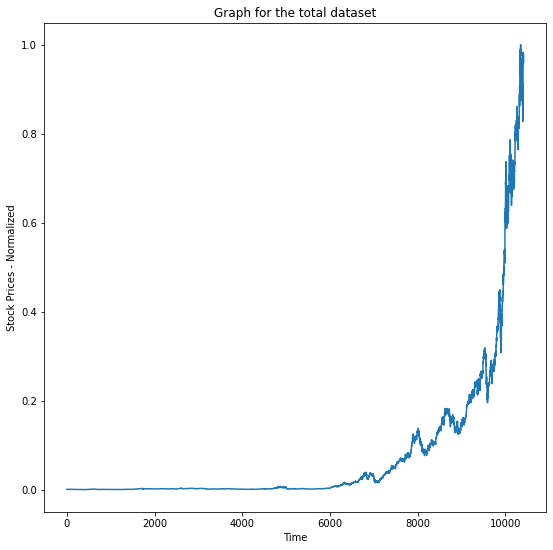

In [ ]:
# Dataset plot for NYSE stock price - without normalization
plt.figure(figsize=(9, 9))
plt.plot(normalized_ds)
plt.title("Graph for the total dataset")
plt.xlabel('Time')
plt.ylabel('Stock Prices - Normalized')
plt.show()

In [ ]:
#Number of iterations
num_of_iterations = -400
final_ts = normalized_ds[num_of_iterations:]
final_ts

10017    0.664049
10018    0.664488
10019    0.619753
10020    0.644484
10021    0.623436
           ...   
10412    0.976698
10413    0.959332
10414    0.957683
10415    0.980380
10416    0.961805
Length: 400, dtype: float64

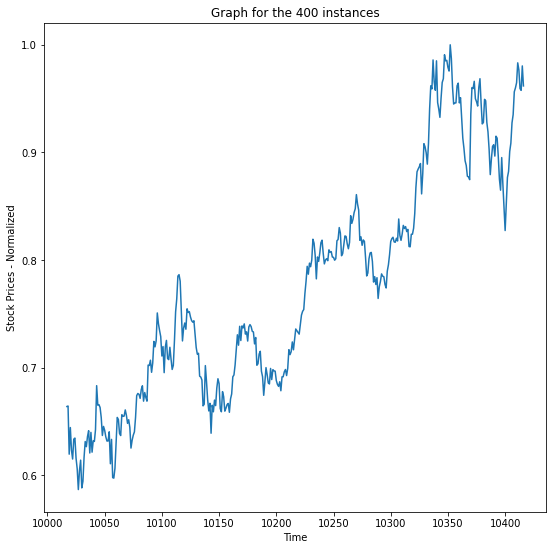

In [ ]:
# Dataset plot for NYSE stock price - with normalization
plt.figure(figsize=(9, 9))
plt.plot(final_ts)
plt.title("Graph for the 400 instances")
plt.xlabel("Time")
plt.ylabel("Stock Prices - Normalized")
plt.show()

In [ ]:
# Splitting the entire data to training set and testing set
temp_training_vals, test_vals = train_test_split(final_ts, test_size=0.2, shuffle=False)

#Splitting the train data to training set and validation set
trainings_vals, validation_vals = train_test_split(temp_training_vals, test_size=0.2, shuffle=False)

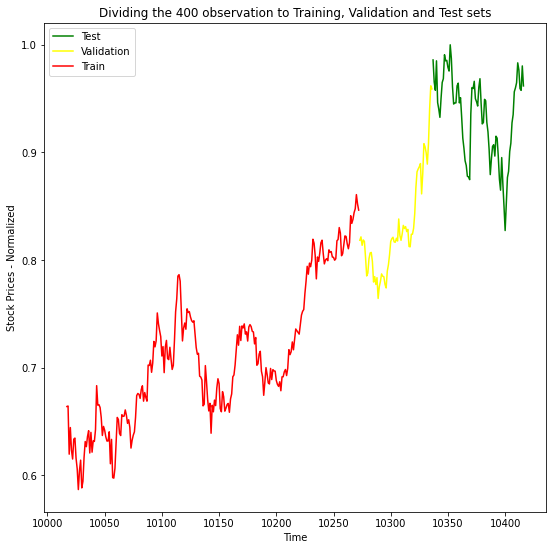

In [ ]:
# Plot of normalized training and testing datapoints that we use for LSTM in the following code
plt.figure(figsize=(9, 9))
plt.plot(test_vals, color = 'green', label = 'Test')
plt.plot(validation_vals, color = 'yellow', label = 'Validation')
plt.plot(trainings_vals, color = 'red', label = 'Train')
plt.title("Dividing the 400 observation to Training, Validation and Test sets")
plt.xlabel("Time")
plt.ylabel("Stock Prices - Normalized")
plt.legend()
plt.show()

In [ ]:
# Input-Output split into list of sequential windows
def splitting_win_for_input_outputor_input_output(inp, wind, fp):
        w = []
        p = []
        for i in inp.index:
            # Find the ending index
            e = i + wind - 1
            # Check if index out of bounds
            if e + fp > inp.index[-1]:
                break   
            # Split into input and output sequences             
            xs = inp.loc[i:e]
            ys = inp[e + fp]
            w.append(xs)
            p.append(ys)
        return np.array(w), np.array(p)

In [ ]:
# Long-Short Time Memory 
class LSTM:
    # Initialization of weights and bias of LSTM gates.
    def __init__(self, x_dim, y_dim, h, c, lr_rate):
        # Dimension of input(X)
        self.x_dim = x_dim 
        # Dimension of output(y)
        self.y_dim = y_dim
        # No. of neurons in hidden layer
        self.h = h
        # No. of lstm cells
        self.c = c 
        # learning rate
        self.lr_rate = lr_rate

        # forget gate states storage
        self.f_state = [np.zeros((hneurons,1)) for i in range(c)]
        #final weight
        self.final_weight = np.random.random((y_dim, hneurons))
        #final bias
        self.final_bias= np.random.random((y_dim, 1))
        # weights of forget gate
        self.forget_gate_weight = np.random.random((hneurons, x_dim + hneurons))/(np.sqrt(x_dim + self.h))
        # bias of forget gate
        self.forget_gate_bias = np.random.random((hneurons, 1))
        # input gate storage
        self.i_state = [np.zeros((hneurons,1)) for i in range(c)]
        # weights of input gate
        self.input_gate_weight = np.random.random((hneurons, x_dim + hneurons))/(np.sqrt(x_dim + self.h))
        # bias of input gate
        self.input_gate_bias = np.random.random((hneurons, 1))
        # cell candidates gate states storage
        self.cand_state = [np.zeros((hneurons,1)) for i in range(c)]
        # weights of cell state gate
        self.cell_gate_weight = np.random.random((hneurons, x_dim + hneurons))/(np.sqrt(x_dim + self.h))
        #bias of cell state gate
        self.cell_bias = np.random.random((hneurons, 1))
        # cell gate states storage
        self.cell_state = [np.zeros((hneurons,1)) for i in range(c)]
        # weights of output gate
        self.output_gate_weight = np.random.random((hneurons, x_dim + hneurons))/(np.sqrt(x_dim + self.h))
        #bias for output
        self.output_bias = np.random.random((hneurons, 1))
        # output gate storage
        self.o_state = [np.zeros((hneurons,1)) for i in range(c)]
        # hidden gate states storage
        self.h_state = [np.zeros((hneurons,1)) for i in range(c)]

    def pass_forward_stage(self,x):
        ## making x into an array 
        self.x=np.array(x)
        ## Loop through using the activation functions
        # 
        for g in range(1, self.c):
            ## Forward Pass for c iterations
            and_c = self.tanh_function( self.cell_gate_weight @ np.vstack( ( self.h_state[g-1], self.x[g] ) ) + self.cell_bias)
            self.cand_state[g] = and_c
            k = self.sigmoid( self.forget_gate_weight @ np.vstack( ( self.h_state[g-1], self.x[g] ) ) + self.forget_gate_bias)
            q = self.sigmoid( self.output_gate_weight @ np.vstack( ( self.h_state[g-1], self.x[g] ) ) + self.output_bias)
            v = self.sigmoid( self.input_gate_weight @ np.vstack( ( self.h_state[g-1], self.x[g] ) ) + self.input_gate_bias)
            w = k * self.cell_state[g-1] + v * and_c
            z = q*self.tanh_function(w)
            self.f_state[g] = k
            self.o_state[g] = q
            self.i_state[g] = v
            self.cell_state[g] = w      
            self.h_state[g] = z
        return self.final_weight@self.h_state[-1]+self.final_bias

    def pass_backward_stage(self, yt, yp):
        # creating a zero array for Storeing delta for cell gate
        dc = [np.zeros((self.h,1)) for i in range(self.c+1)]
        # creating a zero array for Storeing delta for forget gate
        delta_final_state = [np.zeros((self.h,1)) for i in range(self.c+1)]
        # creating a zero array for Storeing delta for output gate
        delta_output_state = [np.zeros((self.h,1)) for i in range(self.c+1)]
        # creating a zero array for Storeing delta for canditate gate
        dcs = [np.zeros((self.h,1)) for i in range(self.c+1)]
        # creating a zero array for Storeing delta for input gate
        delta_input_state = [np.zeros((self.h,1)) for i in range(self.c+1)]
        # creating a zero array for Storeing delta for hidden gate
        delta_hidden_state = [np.zeros((self.h,1)) for i in range(self.c+1)]
        
        # Using zeroes_like to get an array with same dimension
        dwo = np.zeros_like(self.output_gate_weight)
        dob = np.zeros_like(self.output_bias)
        
        # Using zeroes_like to get an array with same dimension
        dwi = np.zeros_like(self.input_gate_weight)
        dcb = np.zeros_like(self.cell_bias)
        
        # Using zeroes_like to get an array with same dimension    
        dwc = np.zeros_like(self.cell_gate_weight)
        dfw = np.zeros_like(self.final_weight)
        
        # Using zeroes_like to get an array with same dimension for bias
        dfinalb = np.zeros_like(self.final_bias)
        dib = np.zeros_like(self.input_gate_bias)
        
        # Using zeroes_like to get an array with same dimension for forget gate
        delta_wf = np.zeros_like(self.forget_gate_weight)
        dfb = np.zeros_like(self.forget_gate_bias)

        # Calculate the final deltas of weight and bias
        de = yt - yp
        dfw = de * self.h_state[-1].T
        dfinalb = de 

        for t in reversed(range(self.c)):
            # Delta for hidden state
            delta_hidden_state[t] = self.final_weight.T @ de + delta_hidden_state[t+1]
            # Delta for output state
            delta_output_state[t] = self.tanh_function(self.cell_state[t]) * delta_hidden_state[t] * self.sig_p(self.h_state[t])
            # Delta for cell state
            dcs[t] = self.o_state[t] * delta_hidden_state[t] * self.tanh_p(self.cell_state[t]) + dcs[t+1]
            # Delta for forget state
            delta_final_state[t] = self.cell_state[t-1] * dcs[t] * self.sig_p(self.f_state[t])
            # Delta for canditate state
            dc[t] = self.i_state[t] * dcs[t] * self.tanh_p(self.cand_state[t])
            # Delta for input state
            delta_input_state[t] = self.cand_state[t] * dcs[t] * self.sig_p(self.input_gate_weight[t])
            
            z = np.vstack((self.h_state[t-1], self.x[t]))

            # Accumulate all the values of deltas
            delta_wf += delta_final_state[t] @ z.T
            dfb += delta_final_state[t]
            dwi += delta_input_state[t] @ z.T
            dib += delta_input_state[t]
            dwo += delta_output_state[t] @ z.T
            dob += delta_output_state[t]
            dwc += dcs[t] @ z.T
            dcb += dcs[t]            
        return dfw, dfinalb, delta_wf / self.c, dfb / self.c, dwi / self.c, dib / self.c, dwo / self.c, dob / self.c, dwc / self.c, dcb / self.c
    
    

    ##Training
    def fit(self, epochs, x, y, xv=None, yv=None):
      # Validation loss for each epoch
        valid_loss_arr = []
        # Training loss for each epoch 
        train_loss_arr = []
        
        for dum in range(epochs):
            val_loss = 0 
            train_loss = 0            
                   
            for n in range(len(x)):
                yp = self.pass_forward_stage(x[n])

                dfw, dfb, dwt_f, dfbias, di, dib, dwo, dob, dwt_c, dcb = self.pass_backward_stage(y[n], yp)

                self.forget_gate_weight = self.forget_gate_weight + (self.lr_rate * dwt_f)
                self.forget_gate_bias = self.forget_gate_bias + (self.lr_rate * dfbias)

                self.input_gate_weight = self.input_gate_weight + (self.lr_rate * di)
                self.input_gate_bias = self.input_gate_bias + (self.lr_rate * dib)

                self.cell_gate_weight = self.cell_gate_weight + (self.lr_rate * dwt_c)
                self.cell_bias = self.cell_bias + (self.lr_rate * dcb)

                self.output_gate_weight = self.output_gate_weight + (self.lr_rate * dwo)
                self.output_bias = self.output_bias + (self.lr_rate * dob)                

                self.final_weight = self.final_weight + (self.lr_rate * dfw)
                self.final_bias = self.final_bias + (self.lr_rate * dfb) 

                train_loss += ((y[n] - yp)**2)/2

            # Check if the model is overfitting or not
            if xv is not None and yv is not None:
              ypv = self.predict(xv)
              ypv = ypv.reshape((ypv.shape[0], 1))
              ytv = ytv.reshape((yv.shape[0], 1))

              val_loss = np.sum((yv - ypv)**2 , axis =0)
              val_loss/=2
              ### append the array validation loss array.
              valid_loss_arr.append(val_loss)
            train_loss_arr.append(train_loss)
        
        if xv is not None:
          if yv is not None:
            ### np.concatenate is Join a sequence of arrays along an existing axis.
            vl_conc = np.concatenate(valid_loss_arr)
            tl_conc = np.concatenate(train_loss_arr)
            return tl_conc, vl_conc

    # Sigmoid function
    def sigmoid(self, z):
        sig_first = np.exp(-z)
        sig_second = sig_first + 1
        sig = 1/sig_second
        return sig
     # Derivative of sigmoid function
    def sig_p(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    # Function to predict price of the next day
    def predict(self, inp):         
        yp = []
        for each in range(len(inp)):
            yp.append(self.pass_forward_stage(inp[each]))            
        res = np.concatenate(yp)
        return res
      
    # Tanh function
    def tanh_function(self, z):
        return np.tanh(z)
         
     # Derivative of tanh function
    def tanh_p(self, z):
        return 1-(self.tanh_function(z)**2)
    
    
    


In [ ]:
#number of input neurons
ni=15
#number of input neurons
no=1
#number of hidden neurons
hneurons=15
#number of epochs
ne=400
learning_rate = 0.1
#splitting the dataset 
xtrain, ytrain = splitting_win_for_input_outputor_input_output(temp_training_vals, ni, no)
xtest, ytest = splitting_win_for_input_outputor_input_output(test_vals, ni, no)

In [ ]:
lstm = LSTM(1,1,hneurons,ni,learning_rate)
lstm.fit(ne, xtrain, ytrain)

ValueError: ignored

In [ ]:
#train prediction
train_predict = lstm.predict(xtrain)
#test prediction
test_predict = lstm.predict(xtest)

NameError: ignored

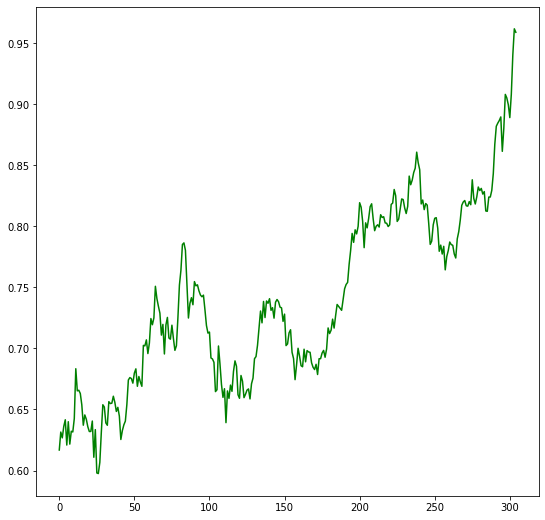

In [ ]:
## Plot for real Value vs Predicted Value for the training dataset
plt.figure(figsize=(9, 9))
plt.plot(ytrain, color='green', label='Real Value')
plt.plot(train_predict, color='red', label='Prediction Value')
plt.title("Real Value vs Predicted Value for the Training Dataset")
plt.xlabel("Time")
plt.ylabel("Stock Price - Normalized")
plt.legend()
plt.show()

In [ ]:
## Real Value vs Predicted Value for the Testing Dataset

plt.figure(figsize=(9, 9))
plt.plot(ytest, color='green', label='Real Value')
plt.plot(test_predict, color='red', label='Prediction Value')
plt.title("Real Value vs Predicted Value for the Testing Dataset")
plt.xlabel('Time')
plt.ylabel('Stock Price - Normalized')
plt.legend()
plt.show()

In [ ]:
## Printing all the resultant values
print("PARAMETERS:")
print("Number of Input Layers: ", ni)
print("Number of Output Layers: ", no)
print("Number of Hidden Neurons: ", hneurons)
print("Number of Epochs: ", ne)
print("Learning Rate: ", learning_rate)
print("Number of Observations: ", -1*num_of_iterations)
print("RESULT:")
print("RMSE for training set: ", mse(ytrain, train_predict, squared = False))
print("RMSE for testing set:  ", mse(ytest, test_predict, squared = False))
print("MAE for training set: ", mae(ytrain, train_predict))
print("MAE for testing set:  ", mae(ytest, test_predict))
print("R2 Score for training set: ", r2(ytrain, train_predict))
print("R2 Score for testing set: ", r2(ytest, test_predict))